# Batched graph classification

classifying 8 types of regular graphs, implemented in the synthetic dataset **data.MiniGCDataset**, as below:
![](https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/batch/dataset_overview.png)

In [9]:
import matplotlib.pyplot as plt
import networkx as nx
import dgl
import dgl.function as fn
from dgl.data import MiniGCDataset # only available in 0.2v
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

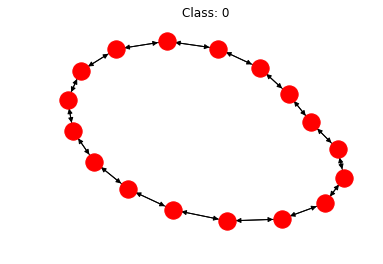

In [2]:
# A dataset with 80 samples, each graph is
# of size in range [10, 20]
dataset = MiniGCDataset(80, 10, 20)# (num_graphs, min_num_nodes, max_num_nodes)
graph, label = dataset[0]
fig, ax = plt.subplots()
nx.draw(graph.to_networkx(), ax=ax)
ax.set_title('Class: {:d}'.format(label))
plt.show()

# Form a graph mini-batch

While images can be easily stacked together to obtain batches, e.g two images of $32\times32$ become $2\times32\times32$ <br>
batching graph inputs has two challenges:

*  Graphs are sparse
*  Graphs can have various length (e.g. number of nodes and edges)

DGL provides a dgl.batch(), which adresses the problem by considering a batch as a large graph that has many disjoint connected components

<img src="https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/batch/batch.png" width="800">


In [3]:
# form a mini-batch from a given list of graph and label pairs.
def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    # the return type of dgl.batch() is still a graph
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

# Graph Classifier

The graph classification can be proceeded as follows:

![](https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/batch/graph_classifier.png)

1.  From a batch of graphs, we first perform message passing/graph convolution for nodes to “communicate” with others. 
<br>

2.  After message passing, we compute a tensor for graph representation from node (and edge) attributes. This step may be called “readout/aggregation” interchangeably. 
<br>

3.  Finally, the graph representations can be fed into a classifier g to predict the graph labels.

# Graph Convolution

The graph convolution operation is in the form of 
$$h^{(l+1)}_v=ReLU(\ b^{(l)}+\frac{1}{|N_{(v)}|}∑_{u\in N_{(v)}}h^{(l)}_u W^{(l)}\ )$$
the average is to balance nodes with different degrees
<br>

**N.B.** the self edges added in the dataset initialization allows to include the original node feature $h^{(l)}_v$ when taking the average.

In [4]:
# Define message function, which sends a message of node feature h and saves it in mailbox as m.
msg = fn.copy_src(src='h', out='m')

def reduce(nodes):
    """Take an average over all neighbor node features h_u and use it to
    overwrite the original node feature."""
    accum = torch.mean(nodes.mailbox['m'], dim=1)
    return {'h': accum}

class NodeApplyModule(nn.Module):
    """Update the node feature hv with ReLU(Whv+b)."""
    def __init__(self, in_feats, out_feats, activation):
        super().__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation

    def forward(self, node):
        h = self.linear(node.data['h'])
        h = self.activation(h)
        return {'h' : h}

class GCN(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super().__init__()
        self.apply_mod = NodeApplyModule(in_feats, out_feats, activation)

    def forward(self, g, feature):
        # Initialize the node features with h.
        g.ndata['h'] = feature
        g.update_all(msg, reduce)
        g.apply_nodes(func=self.apply_mod)
        return g.ndata.pop('h')

# Readout and Classification

1.  We consider the *initial features* of the nodes to be their degrees. 

2.  Apply two rounds of *graph convolution*

3.  Perform a graph *readout* by averaging over all node features for each graph in the batch

$$ h_g= \frac{1}{|\mathcal{V}|} \sum_{v\in \mathcal{V}} h_v $$

In DGL, **dgl.mean_nodes()** handles this task for a batch of graphs with variable size. We then feed our graph representations into a classifier with one linear layer to obtain pre-softmax logits.

In [8]:
class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super().__init__()

        self.layers = nn.ModuleList([
            GCN(in_dim, hidden_dim, F.relu),
            GCN(hidden_dim, hidden_dim, F.relu)])
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        # For undirected graphs, in_degree is the same as
        # out_degree.
        h = g.in_degrees().view(-1, 1).float()
        for conv in self.layers:
            # conv returns the new set of node's features
            h = conv(g, h)
        g.ndata['h'] = h
        # do avarage pooling
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)

# Setup and Training

Use synthetic dataset of 500 graphs with [10,20] nodes. <br>
320 graphs constitute a training set <br>
100 graphs constitute a validation set <br>
80 graphs constitute a test set.

In [23]:
# Create training and test sets.
trainset = MiniGCDataset(320, 10, 20)
valset = MiniGCDataset(80, 10, 20)
testset = MiniGCDataset(80, 10, 20)
# Use PyTorch's DataLoader and the collate function
# defined before.
data_loader = DataLoader(trainset, batch_size=32, shuffle=True,
                         collate_fn=collate)
val_loader = DataLoader(valset, batch_size=32, shuffle=True,
                         collate_fn=collate)
# Create model
model = Classifier(1, 256, trainset.num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_epoch_losses = []
val_epoch_losses = []
for epoch in range(200):
    ######## Training ##########
    model.train()
    epoch_loss = 0
    for (bg, label) in (data_loader):
        prediction = model(bg)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    
    ######## Validation ##########
    model.eval()
    val_epoch_loss = 0
    for bg,label in val_loader:
        prediction = model(bg)
        loss = loss_func(prediction,label)
        val_epoch_loss += loss.item()
    
    # make the losses comparable
    epoch_loss /= trainset.num_graphs
    val_epoch_loss /= valset.num_graphs
    
    print('Epoch {}, loss {:.4f}, validation {:.4f}'.format(epoch, epoch_loss, val_epoch_loss))
    train_epoch_losses.append(epoch_loss)
    val_epoch_losses.append(val_epoch_loss)    

/anaconda3/lib/python3.6/site-packages/dgl/base.py:18: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  warnings.warn(msg)


Epoch 0, loss 0.0676, validation 0.0816
Epoch 1, loss 0.0624, validation 0.0698
Epoch 2, loss 0.0588, validation 0.0683
Epoch 3, loss 0.0558, validation 0.0634
Epoch 4, loss 0.0531, validation 0.0595
Epoch 5, loss 0.0504, validation 0.0571
Epoch 6, loss 0.0483, validation 0.0524
Epoch 7, loss 0.0456, validation 0.0518
Epoch 8, loss 0.0432, validation 0.0476
Epoch 9, loss 0.0410, validation 0.0472
Epoch 10, loss 0.0395, validation 0.0449
Epoch 11, loss 0.0379, validation 0.0425
Epoch 12, loss 0.0365, validation 0.0391
Epoch 13, loss 0.0352, validation 0.0381
Epoch 14, loss 0.0342, validation 0.0375
Epoch 15, loss 0.0332, validation 0.0376
Epoch 16, loss 0.0321, validation 0.0360
Epoch 17, loss 0.0317, validation 0.0346
Epoch 18, loss 0.0305, validation 0.0357
Epoch 19, loss 0.0293, validation 0.0344
Epoch 20, loss 0.0305, validation 0.0324
Epoch 21, loss 0.0289, validation 0.0336
Epoch 22, loss 0.0285, validation 0.0310
Epoch 23, loss 0.0277, validation 0.0317
Epoch 24, loss 0.0266, val

Epoch 198, loss 0.0093, validation 0.0125
Epoch 199, loss 0.0094, validation 0.0119


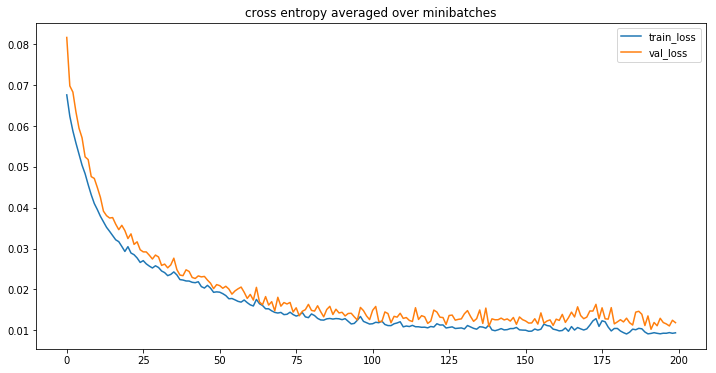

In [29]:
plt.figure(figsize=(12,6))
plt.title('cross entropy averaged over minibatches')
plt.plot(train_epoch_losses, label='train_loss')
plt.plot(val_epoch_losses, label='val_loss')
plt.legend()
plt.show()

In [30]:
# The trained model is evaluated on the test set created
model.eval()
# Convert a list of tuples to two lists
test_X, test_Y = map(list, zip(*testset))
test_bg = dgl.batch(test_X)
test_Y = torch.tensor(test_Y).float().view(-1, 1)
probs_Y = torch.softmax(model(test_bg), 1)
sampled_Y = torch.multinomial(probs_Y, 1)
argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)

print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
    (test_Y == sampled_Y.float()).sum().item() / len(test_Y) * 100))
print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
    (test_Y == argmax_Y.float()).sum().item() / len(test_Y) * 100))

Accuracy of sampled predictions on the test set: 82.5000%
Accuracy of argmax predictions on the test set: 91.250000%


/anaconda3/lib/python3.6/site-packages/dgl/base.py:18: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  warnings.warn(msg)
